In [1]:
import numpy as np
from scipy.stats import entropy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def u_2_max(p):
    p_sorted = np.sort(p)[::-1]
    return 1-(np.abs(p_sorted[0] - p_sorted[1]))

def hybrid_uncertainty(p):
    p = np.asarray(p)
    p /= p.sum()  
    u2 = u_2_max(p)
    ent = entropy(p)
    return round(((u2) + (ent / np.log(len(p)))) / 2, 3)

In [3]:
def normalize_minmax(arr):
    arr = np.asarray(arr)
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    if max_val - min_val == 0:
        return np.zeros_like(arr) 
    return (arr - min_val) / (max_val - min_val)

In [4]:
with open("p_all_sd.pkl", "rb") as f:
    proba_data = pickle.load(f)

# Calcul des incertitudes
uncertainty_results = {}

In [7]:
%%time
for dataset_name, methods_dict in proba_data.items():
    uncertainty_results[dataset_name] = {}
    for method, prob_array in methods_dict.items():
        u2_vals = np.apply_along_axis(u_2_max, 1, prob_array)
        hybrid_vals = np.apply_along_axis(hybrid_uncertainty, 1, prob_array)
        hybrid_vals_norm = normalize_minmax(hybrid_vals) 
        uncertainty_results[dataset_name][method] = {
            "Top2Gap": u2_vals,
            "Hybrid": hybrid_vals_norm
        }

# Sauvegarder les incertitudes dans un nouveau fichier
with open("uncertainty_metrics.pkl", "wb") as f:
    pickle.dump(uncertainty_results, f)

✅ Incertitudes calculées et sauvegardées dans 'uncertainty_metrics.pkl'
CPU times: total: 26 s
Wall time: 26 s


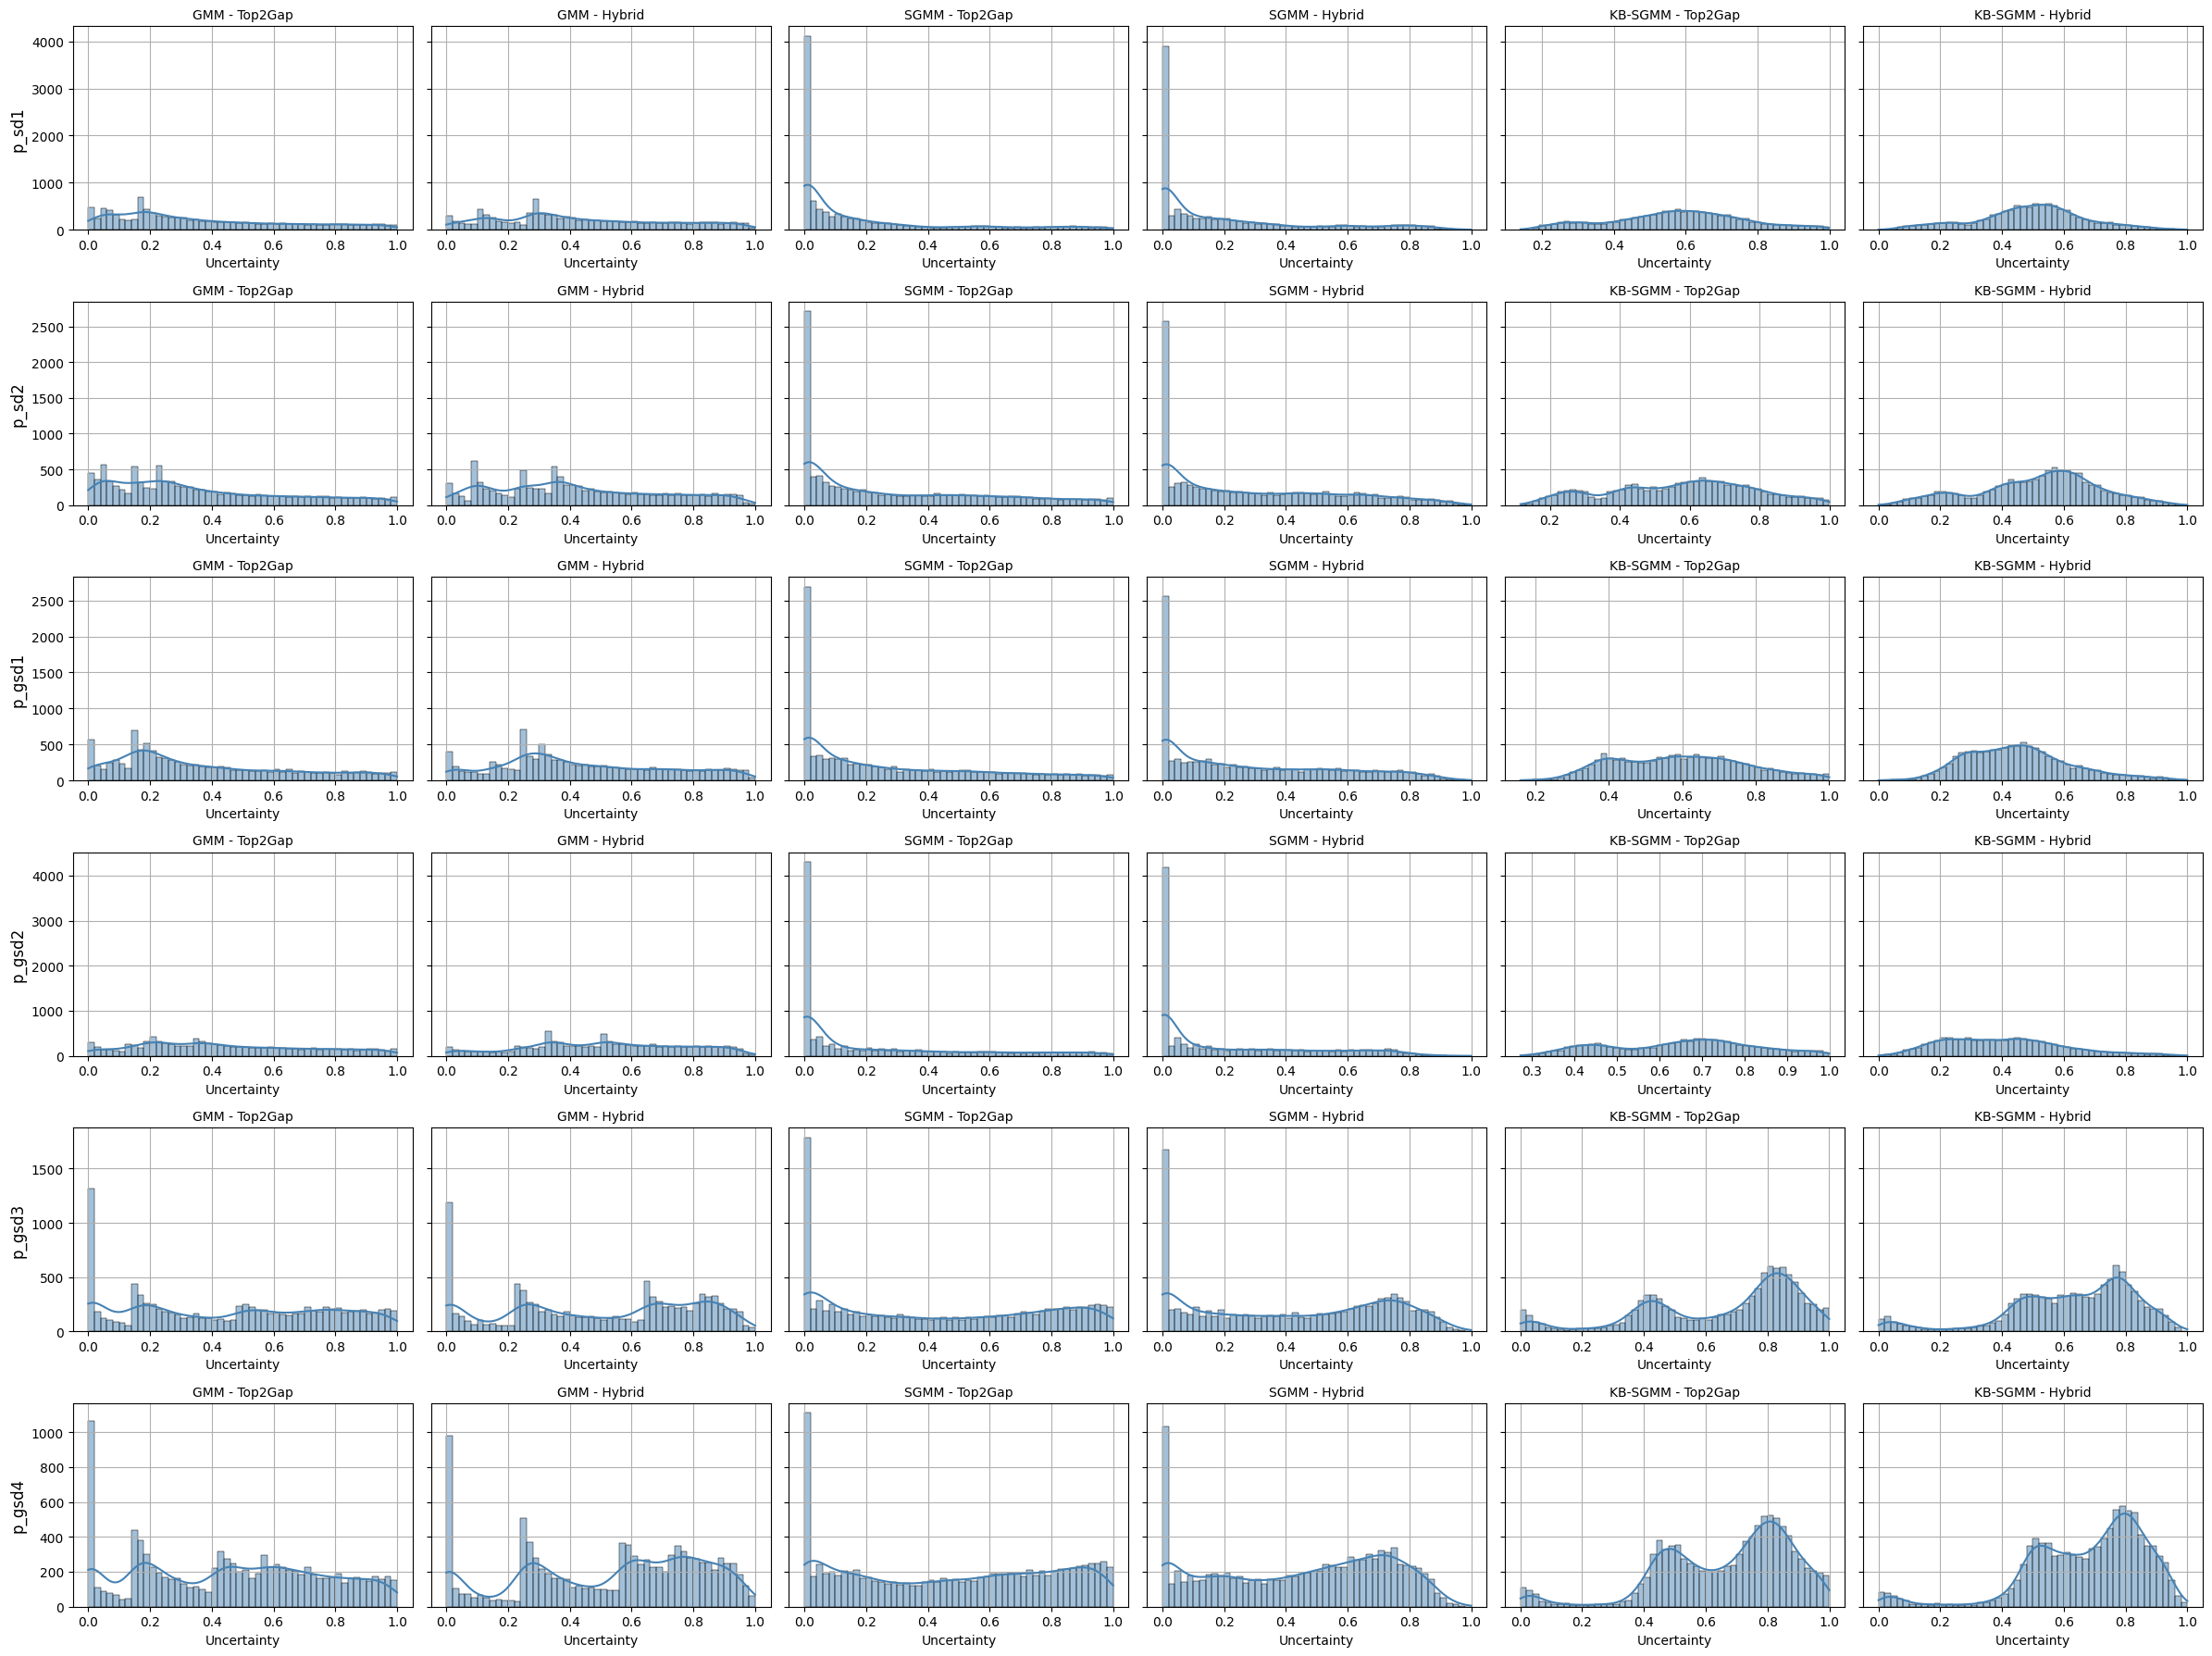

In [10]:
dataset_names = list(uncertainty_results.keys())  # e.g. ['p_sd1', ..., 'p_sd6']
methods = ["GMM", "SGMM", "KB-SGMM"]
metrics = ["Top2Gap", "Hybrid"]

# Préparer la grille
n_datasets = len(dataset_names)
n_cols = len(methods) * len(metrics)  # 6 colonnes
fig, axes = plt.subplots(nrows=n_datasets, ncols=n_cols, figsize=(4 * n_cols, 3 * n_datasets), sharey='row')

# Plot
for i, dataset in enumerate(dataset_names):
    for j, method in enumerate(methods):
        for k, metric in enumerate(metrics):
            col = j * len(metrics) + k
            ax = axes[i, col] if n_datasets > 1 else axes[col]
            
            values = uncertainty_results[dataset][method][metric]
            sns.histplot(values, bins=50, kde=True, ax=ax, color='steelblue')
            ax.set_title(f"{method} - {metric}", fontsize=10)
            ax.set_xlabel("Uncertainty")
            ax.set_ylabel("Density" if col == 0 else "")
            ax.grid(True)

    axes[i, 0].set_ylabel(f"{dataset}", fontsize=12)

plt.tight_layout()

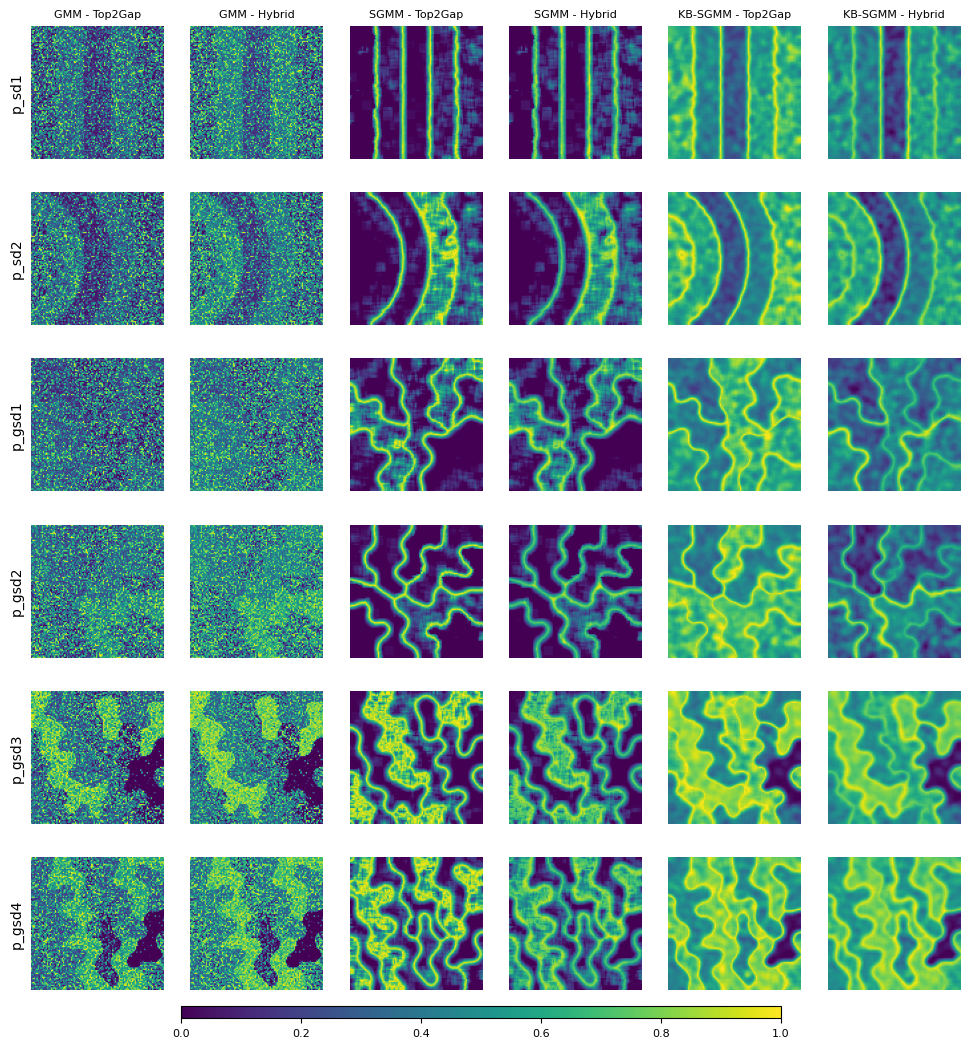

In [11]:
fig, axes = plt.subplots(
    nrows=n_datasets, 
    ncols=n_cols, 
    figsize=(2 * n_cols, 2.1 * n_datasets),  # format proche A4 paysage
)

vmin, vmax = 0, 1  # pour toutes les cartes

# Pour garder un handle d’image pour colorbar
img_for_colorbar = None

for i, dataset in enumerate(dataset_names):
    for j, method in enumerate(methods):
        for k, metric in enumerate(metrics):
            col = j * len(metrics) + k
            ax = axes[i, col] if n_datasets > 1 else axes[col]

            data = uncertainty_results[dataset][method][metric]
            img = data.reshape(100, 100)

            im = ax.imshow(img, cmap="viridis", vmin=vmin, vmax=vmax)

            if i == 0:
                ax.set_title(f"{method} - {metric}", fontsize=8)
            else:
                ax.set_title("")

            ax.axis("off")

            if col == 0:
                ax.text(
                    -0.05, 0.5, dataset,
                    fontsize=10,
                    ha='right',
                    va='center',
                    rotation=90,
                    transform=ax.transAxes
                )

            if img_for_colorbar is None:
                img_for_colorbar = im

# Colorbar horizontale compacte en bas
cbar_ax = fig.add_axes([0.25, 0.09, 0.5, 0.01])
cbar = fig.colorbar(img_for_colorbar, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)
plt.savefig("uncertainty_maps_A4.png", dpi=300, bbox_inches='tight')
plt.show()